# Word Embedding in TF

## How do we represent words in an efficient way?

## One-hot Representation

Each word is represented by one vector with a single 1 and the rest is 0

Example

- Vocab: i, it, california, meh
    * i  = [1 0 0 0]
    * it = [0 1 0 0]
    * california = [0 0 1 0]
    * meh = [0 0 0 1]


## Problems with one-hot representation

- Vocabulary can be large 
    * massive dimension, inefficient computation
- Can’t represent relationship between words 
    * “anxious” and “nervous” are similar but would have completely different representations


## Word Embedding

- Distributed representation
- Continuous values
- Low dimension
- Capture the semantic relationships between words

## How to make WE?

### Representing a word by means of its neighbors

“You shall know a word by the company it keeps.” by Firth, J. R. 1957:11


## Count vs Predict

### Counting

#### Simple but surprisingly effective


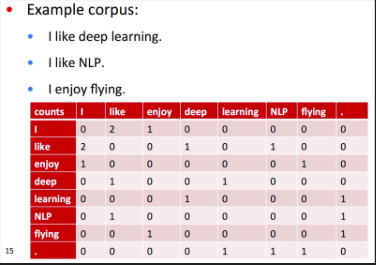

In [1]:
from IPython.display import Image
Image("images/cs224n_counting_example01.png")

### Predicting

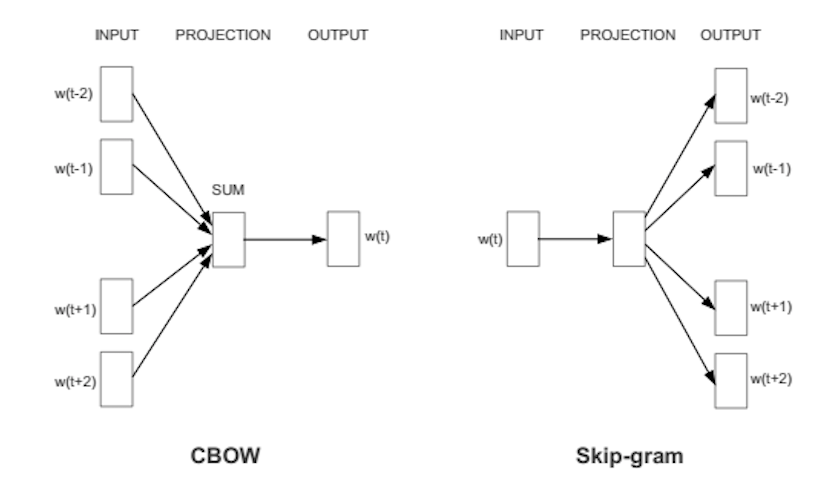

In [3]:
from IPython.display import Image
Image("images/word2vec_diagrams.png")

### Algorithmically, these models are similar, except that CBOW predicts center words from context words, while the skip-gram does the inverse and predicts source context-words from the center words. For example, if we have the sentence: ""The quick brown fox jumps"", then CBOW tries to predict ""brown"" from ""the"", ""quick"", ""fox"", and ""jumps"", while skip-gram tries to predict ""the"", ""quick"", ""fox"", and ""jumps"" from ""brown"".

### Statistically it has the effect that CBOW smoothes over a lot of the distributional information (by treating an entire context as one observation). For the most part, this turns out to be a useful thing for smaller datasets. However, skip-gram treats each context-target pair as a new observation, and this tends to do better when we have larger datasets.

## Implementing word2vec skip-gram

## Softmax approach

so expensive

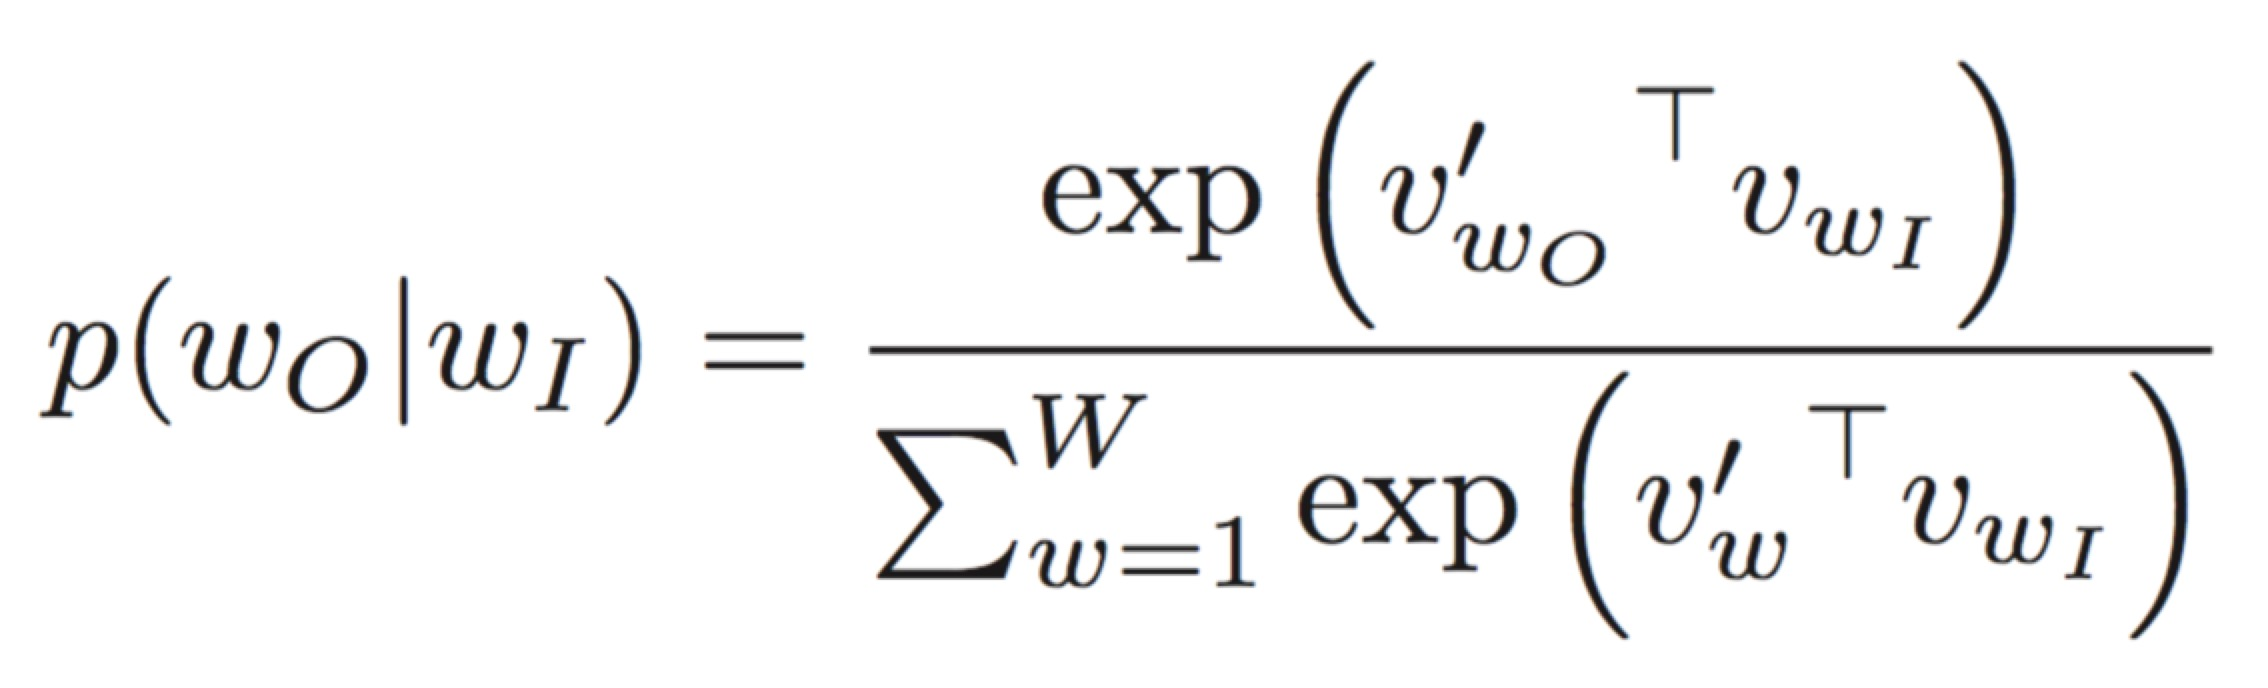

In [4]:
from IPython.display import Image
Image("images/softmax_expensive.jpg")

## Sample-based Approaches

Negative Sampling is a simplified version of Noise Contrastive Estimation(NCE)

- NCE guarantees approximation to softmax
- Negative Sampling doesn’t quarantee to softmax

For more information, see: 
    * Sebastian Rudder’s “On word embeddings - Part 2: Approximating the Softmax” 
    * Chris Dyer’s “Notes on Noise Contrastive Estimation and Negative Sampling”



## Embedding Lookup

tf.nn.embedding_lookup(params, ids, partition_strategy='mod', name=None, validate_indices=True, max_norm=None)

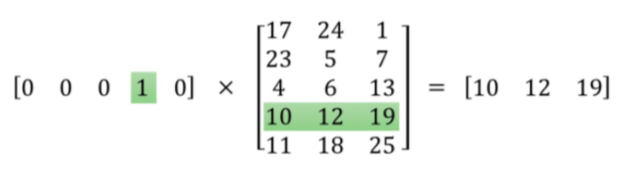

In [5]:
from IPython.display import Image
Image("images/embedding_lookup.png")

## NCE Loss

<pre><code>
tf.nn.nce_loss(
    weights,
    biases,
    labels,
    inputs,
    num_sampled,
    num_classes,
    num_true=1,
    sampled_values=None,
    remove_accidental_hits=False,
    partition_strategy='mod',
    name='nce_loss'
)
</code></pre>

# Word2vec in TensorFlow

## Structure your TensorFlow model

### Phase 1: Assemble graph

1. Import data (with tf.data or placeholders)
2. Define the weights
3. Define the inference model
4. Define loss function
5. Define optimizer

### Phase 2: Compute

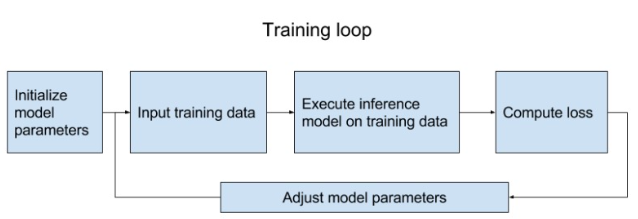

In [11]:
from IPython.display import Image
Image("images/training_loop.png")

### Interactive Coding

In [1]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
print(os.getcwd())

/Users/surkpark/cs20si_study


In [2]:
import sys
sys.path.append(os.getcwd()+"/examples")

In [3]:
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector
import tensorflow as tf

import utils
import word2vec_utils

In [4]:
# Model hyperparameters
VOCAB_SIZE = 50000
BATCH_SIZE = 128
EMBED_SIZE = 128            # dimension of the word embedding vectors
SKIP_WINDOW = 1             # the context window
NUM_SAMPLED = 64            # number of negative examples to sample
LEARNING_RATE = 1.0
NUM_TRAIN_STEPS = 100000
VISUAL_FLD = 'visualization'
SKIP_STEP = 5000

In [5]:
# Parameters for downloading data
DOWNLOAD_URL = 'http://mattmahoney.net/dc/text8.zip'
EXPECTED_BYTES = 31344016
NUM_VISUALIZE = 3000        # number of tokens to visualize

In [6]:
def word2vec(dataset):
    """ Build the graph for word2vec model and train it """
    # Step 1: get input, output from the dataset
    with tf.name_scope('data'):
        iterator = dataset.make_initializable_iterator()
        center_words, target_words = iterator.get_next()

    """ Step 2 + 3: define weights and embedding lookup.
    In word2vec, it's actually the weights that we care about 
    """
    with tf.name_scope('embed'):
        embed_matrix = tf.get_variable('embed_matrix', 
                                        shape=[VOCAB_SIZE, EMBED_SIZE],
                                        initializer=tf.random_uniform_initializer())
        embed = tf.nn.embedding_lookup(embed_matrix, center_words, name='embedding')

    # Step 4: construct variables for NCE loss and define loss function
    with tf.name_scope('loss'):
        nce_weight = tf.get_variable('nce_weight', shape=[VOCAB_SIZE, EMBED_SIZE],
                        initializer=tf.truncated_normal_initializer(stddev=1.0 / (EMBED_SIZE ** 0.5)))
        nce_bias = tf.get_variable('nce_bias', initializer=tf.zeros([VOCAB_SIZE]))

        # define loss function to be NCE loss function
        loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight, 
                                            biases=nce_bias, 
                                            labels=target_words, 
                                            inputs=embed, 
                                            num_sampled=NUM_SAMPLED, 
                                            num_classes=VOCAB_SIZE), name='loss')

    # Step 5: define optimizer
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)
    
    utils.safe_mkdir('checkpoints')

    with tf.Session() as sess:
        sess.run(iterator.initializer)
        sess.run(tf.global_variables_initializer())

        total_loss = 0.0 # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('graphs/word2vec_simple', sess.graph)

        for index in range(NUM_TRAIN_STEPS):
            try:
                loss_batch, _ = sess.run([loss, optimizer])
                total_loss += loss_batch
                if (index + 1) % SKIP_STEP == 0:
                    print('Average loss at step {}: {:5.1f}'.format(index, total_loss / SKIP_STEP))
                    total_loss = 0.0
            except tf.errors.OutOfRangeError:
                sess.run(iterator.initializer)
        writer.close()

In [7]:
def gen():
    yield from word2vec_utils.batch_gen(DOWNLOAD_URL, EXPECTED_BYTES, VOCAB_SIZE, 
                                        BATCH_SIZE, SKIP_WINDOW, VISUAL_FLD)

In [8]:
def main():
    dataset = tf.data.Dataset.from_generator(gen, 
                                (tf.int32, tf.int32), 
                                (tf.TensorShape([BATCH_SIZE]), tf.TensorShape([BATCH_SIZE, 1])))
    word2vec(dataset)

In [9]:
main()

Successfully downloaded ./examples/data/text8.zip
Average loss at step 4999:  65.1
Average loss at step 9999:  18.5
Average loss at step 14999:   9.7
Average loss at step 19999:   6.7
Average loss at step 24999:   5.7
Average loss at step 29999:   5.2
Average loss at step 34999:   5.0
Average loss at step 39999:   4.8
Average loss at step 44999:   4.8
Average loss at step 49999:   4.7
Average loss at step 54999:   4.7
Average loss at step 59999:   4.7
Average loss at step 64999:   4.6
Average loss at step 69999:   4.6
Average loss at step 74999:   4.6
Average loss at step 79999:   4.6
Average loss at step 84999:   4.7
Average loss at step 89999:   4.7
Average loss at step 94999:   4.6
Average loss at step 99999:   4.6


## Need models to be reusable

### Reusable models

- Define a class for your model
- Set up your model in a collection (e.g. map)

If you want to really reuse a model (without rebuilding it)
- For big models that take a long time to build, save the graph_def in a file and then load it


### Model as a class

<pre><code>
class SkipGramModel:
    """ Build the graph for word2vec model """
    def __init__(self, params):
        pass

    def _import_data(self):
        """ Step 1: import data """
        pass

    def _create_embedding(self):
        """ Step 2: define weights. In word2vec, it's actually the weights that we care about """
        pass

    def _create_loss(self):
        """ Step 3 + 4: define the inference + the loss function """
        pass

    def _create_optimizer(self):
        """ Step 5: define optimizer """
        pass

</code></pre>

## Embedding visualization

### Interactive Coding

In [1]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
print(os.getcwd())

/Users/surkpark/cs20si_study


In [2]:
import sys
sys.path.append(os.getcwd()+"/examples")

In [3]:
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector
import tensorflow as tf

import utils
import word2vec_utils

In [4]:
# Model hyperparameters
VOCAB_SIZE = 50000
BATCH_SIZE = 128
EMBED_SIZE = 128            # dimension of the word embedding vectors
SKIP_WINDOW = 1             # the context window
NUM_SAMPLED = 64            # number of negative examples to sample
LEARNING_RATE = 1.0
NUM_TRAIN_STEPS = 100000
VISUAL_FLD = 'visualization'
SKIP_STEP = 5000

In [5]:
# Parameters for downloading data
DOWNLOAD_URL = 'http://mattmahoney.net/dc/text8.zip'
EXPECTED_BYTES = 31344016
NUM_VISUALIZE = 3000        # number of tokens to visualize

In [6]:
class SkipGramModel:
    """ Build the graph for word2vec model """
    def __init__(self, dataset, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.get_variable('global_step', initializer=tf.constant(0), trainable=False)
        self.skip_step = SKIP_STEP
        self.dataset = dataset

    def _import_data(self):
        """ Step 1: import data
        """
        with tf.name_scope('data'):
            self.iterator = self.dataset.make_initializable_iterator()
            self.center_words, self.target_words = self.iterator.get_next()

    def _create_embedding(self):
        """ Step 2 + 3: define weights and embedding lookup.
        In word2vec, it's actually the weights that we care about 
        """
        with tf.name_scope('embed'):
            self.embed_matrix = tf.get_variable('embed_matrix', 
                                                shape=[self.vocab_size, self.embed_size],
                                                initializer=tf.random_uniform_initializer())
            self.embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embedding')

    def _create_loss(self):
        """ Step 4: define the loss function """
        with tf.name_scope('loss'):
            # construct variables for NCE loss
            nce_weight = tf.get_variable('nce_weight', 
                        shape=[self.vocab_size, self.embed_size],
                        initializer=tf.truncated_normal_initializer(stddev=1.0 / (self.embed_size ** 0.5)))
            nce_bias = tf.get_variable('nce_bias', initializer=tf.zeros([VOCAB_SIZE]))

            # define loss function to be NCE loss function
            self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight, 
                                                biases=nce_bias, 
                                                labels=self.target_words, 
                                                inputs=self.embed, 
                                                num_sampled=self.num_sampled, 
                                                num_classes=self.vocab_size), name='loss')
    def _create_optimizer(self):
        """ Step 5: define optimizer """
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss, 
                                                              global_step=self.global_step)

    def _create_summaries(self):
        with tf.name_scope('summaries'):
            tf.summary.scalar('loss', self.loss)
            tf.summary.histogram('histogram loss', self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._import_data()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

    def train(self, num_train_steps):
        saver = tf.train.Saver() # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

        initial_step = 0
        utils.safe_mkdir('checkpoints')
        with tf.Session() as sess:
            sess.run(self.iterator.initializer)
            sess.run(tf.global_variables_initializer())
            ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))

            # if that checkpoint exists, restore from checkpoint
            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(sess, ckpt.model_checkpoint_path)

            total_loss = 0.0 # we use this to calculate late average loss in the last SKIP_STEP steps
            writer = tf.summary.FileWriter('graphs/word2vec/lr' + str(self.lr), sess.graph)
            initial_step = self.global_step.eval()

            for index in range(initial_step, initial_step + num_train_steps):
                try:
                    loss_batch, _, summary = sess.run([self.loss, self.optimizer, self.summary_op])
                    writer.add_summary(summary, global_step=index)
                    total_loss += loss_batch
                    if (index + 1) % self.skip_step == 0:
                        print('Average loss at step {}: {:5.1f}'.format(index, total_loss / self.skip_step))
                        total_loss = 0.0
                        saver.save(sess, 'checkpoints/skip-gram', index)
                except tf.errors.OutOfRangeError:
                    sess.run(self.iterator.initializer)
            writer.close()

    def visualize(self, visual_fld, num_visualize):
        """ run "'tensorboard --logdir='visualization'" to see the embeddings """
        
        # create the list of num_variable most common words to visualize
        word2vec_utils.most_common_words(visual_fld, num_visualize)

        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))

            # if that checkpoint exists, restore from checkpoint
            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(sess, ckpt.model_checkpoint_path)

            final_embed_matrix = sess.run(self.embed_matrix)
            
            # you have to store embeddings in a new variable
            embedding_var = tf.Variable(final_embed_matrix[:num_visualize], name='embedding')
            sess.run(embedding_var.initializer)

            config = projector.ProjectorConfig()
            summary_writer = tf.summary.FileWriter(visual_fld)

            # add embedding to the config file
            embedding = config.embeddings.add()
            embedding.tensor_name = embedding_var.name
            
            # link this tensor to its metadata file, in this case the first NUM_VISUALIZE words of vocab
            embedding.metadata_path = 'vocab_' + str(num_visualize) + '.tsv'

            # saves a configuration file that TensorBoard will read during startup.
            projector.visualize_embeddings(summary_writer, config)
            saver_embed = tf.train.Saver([embedding_var])
            saver_embed.save(sess, os.path.join(visual_fld, 'model.ckpt'), 1)

In [7]:
def gen():
    yield from word2vec_utils.batch_gen(DOWNLOAD_URL, EXPECTED_BYTES, VOCAB_SIZE, 
                                        BATCH_SIZE, SKIP_WINDOW, VISUAL_FLD)

In [8]:
def main():
    dataset = tf.data.Dataset.from_generator(gen, 
                                (tf.int32, tf.int32), 
                                (tf.TensorShape([BATCH_SIZE]), tf.TensorShape([BATCH_SIZE, 1])))
    model = SkipGramModel(dataset, VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()
    model.train(NUM_TRAIN_STEPS)
    model.visualize(VISUAL_FLD, NUM_VISUALIZE)

In [9]:
main()

INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.
./examples/data/text8.zip already exists
Average loss at step 4999:  65.3
Average loss at step 9999:  18.2
Average loss at step 14999:   9.7
Average loss at step 19999:   6.7
Average loss at step 24999:   5.7
Average loss at step 29999:   5.3
Average loss at step 34999:   5.0
Average loss at step 39999:   4.8
Average loss at step 44999:   4.8
Average loss at step 49999:   4.8
Average loss at step 54999:   4.8
Average loss at step 59999:   4.7
Average loss at step 64999:   4.6
Average loss at step 69999:   4.7
Average loss at step 74999:   4.6
Average loss at step 79999:   4.7
Average loss at step 84999:   4.7
Average loss at step 89999:   4.7
Average loss at step 94999:   4.6
Average loss at step 99999:   4.6
INFO:tensorflow:Restoring parameters from checkpoints/skip-gram-99999


# Variable sharing

## word2vec on TensorBoard

What if I have more complex models?

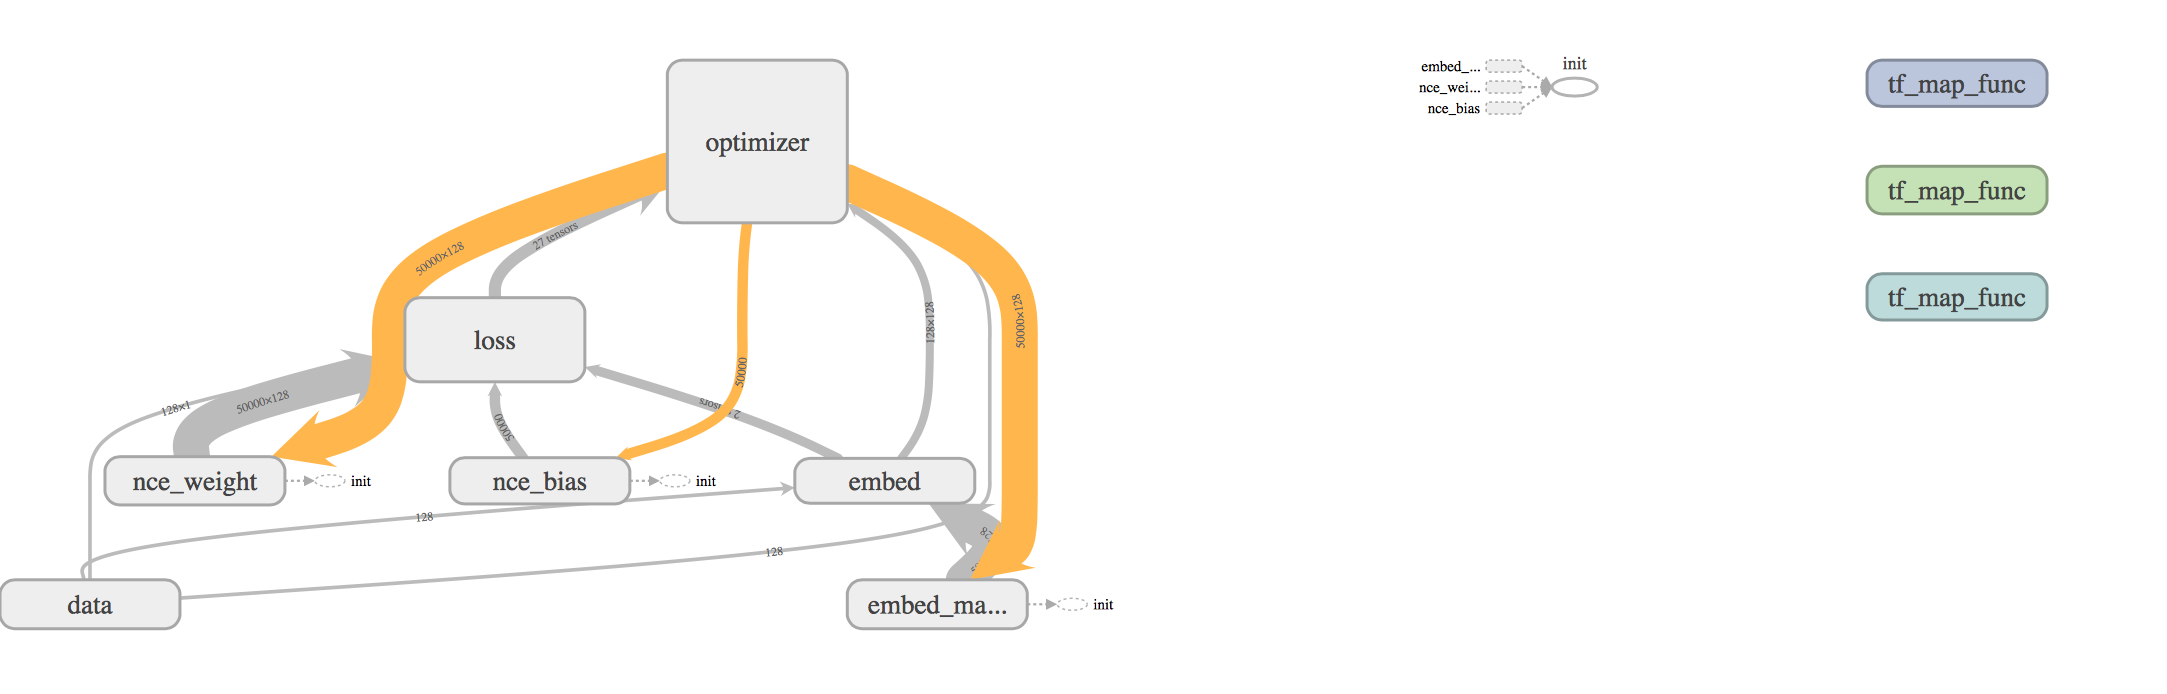

In [10]:
from IPython.display import Image
Image("images/word2vec_simple_graph.png")

## Name scope

### TensorFlow doesn’t know what nodes should be grouped together, unless you tell it to

### Group nodes together with tf.name_scope(name)

<pre><code>
with tf.name_scope(name_of_that_scope):
	# declare op_1
	# declare op_2
	# ...
</code></pre>

<pre><code>
with tf.name_scope('data'):
    iterator = dataset.make_initializable_iterator()
    center_words, target_words = iterator.get_next()
    
with tf.name_scope('embed'):
    embed_matrix = tf.get_variable('embed_matrix', 
                                    shape=[VOCAB_SIZE, EMBED_SIZE], ...)
    embed = tf.nn.embedding_lookup(embed_matrix, center_words)
    
with tf.name_scope('loss'):
    nce_weight = tf.get_variable('nce_weight', shape=[VOCAB_SIZE, EMBED_SIZE], ...)
    nce_bias = tf.get_variable('nce_bias', initializer=tf.zeros([VOCAB_SIZE]))
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight, biases=nce_bias, …)
    
with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)
</code></pre>

## Variable scope

### Name scope vs variable scope
### tf.name_scope() vs tf.variable_scope()


### Variable scope facilitates variable sharing

## Variable sharing: The problem

<pre><code>
def two_hidden_layers(x):
    w1 = tf.Variable(tf.random_normal([100, 50]), name='h1_weights')
    b1 = tf.Variable(tf.zeros([50]), name='h1_biases')
    h1 = tf.matmul(x, w1) + b1

    w2 = tf.Variable(tf.random_normal([50, 10]), name='h2_weights')
    b2 = tf.Variable(tf.zeros([10]), name='2_biases')
    logits = tf.matmul(h1, w2) + b2
    return logits
</code></pre>

What will happen if we make these two calls?

<pre><code>
logits1 = two_hidden_layers(x1)
logits2 = two_hidden_layers(x2)
</code></pre>

## Sharing Variable: The problem

Two sets of variables are created.

You want all your inputs to use the same weights and biases!


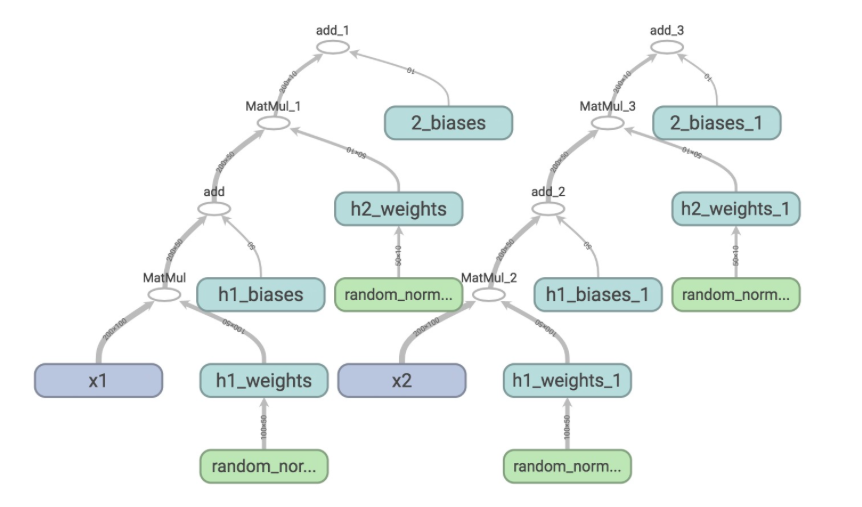

In [12]:
from IPython.display import Image
Image("images/shareing_variable_problem.png")

## tf.get_variable()

<pre><code>
tf.get_variable(name, shape, initializer)
</code></pre>

- If a variable with <name> already exists, reuse it
- If not, initialize it with <shape> using <initializer>


<pre><code>
def two_hidden_layers(x):
    assert x.shape.as_list() == [200, 100]
    w1 = tf.get_variable("h1_weights", [100, 50], initializer=tf.random_normal_initializer())
    b1 = tf.get_variable("h1_biases", [50], initializer=tf.constant_initializer(0.0))
    h1 = tf.matmul(x, w1) + b1
    assert h1.shape.as_list() == [200, 50]  
    w2 = tf.get_variable("h2_weights", [50, 10], initializer=tf.random_normal_initializer())
    b2 = tf.get_variable("h2_biases", [10], initializer=tf.constant_initializer(0.0))
    logits = tf.matmul(h1, w2) + b2
    return logits
logits1 = two_hidden_layers(x1)
logits2 = two_hidden_layers(x2)
</code></pre>

### ValueError: Variable h1_weights already exists, disallowed. Did you mean to set reuse=True in VarScope?

<pre><code>
def two_hidden_layers(x):
    assert x.shape.as_list() == [200, 100]
    w1 = tf.get_variable("h1_weights", [100, 50], initializer=tf.random_normal_initializer())
    b1 = tf.get_variable("h1_biases", [50], initializer=tf.constant_initializer(0.0))
    h1 = tf.matmul(x, w1) + b1
    assert h1.shape.as_list() == [200, 50]  
    w2 = tf.get_variable("h2_weights", [50, 10], initializer=tf.random_normal_initializer())
    b2 = tf.get_variable("h2_biases", [10], initializer=tf.constant_initializer(0.0))
    logits = tf.matmul(h1, w2) + b2
    return logits
with tf.variable_scope('two_layers') as scope:
    logits1 = two_hidden_layers(x1)
    scope.reuse_variables()
    logits2 = two_hidden_layers(x2)
</code></pre>

### Put your variables within a scope and reuse all variables within that scope

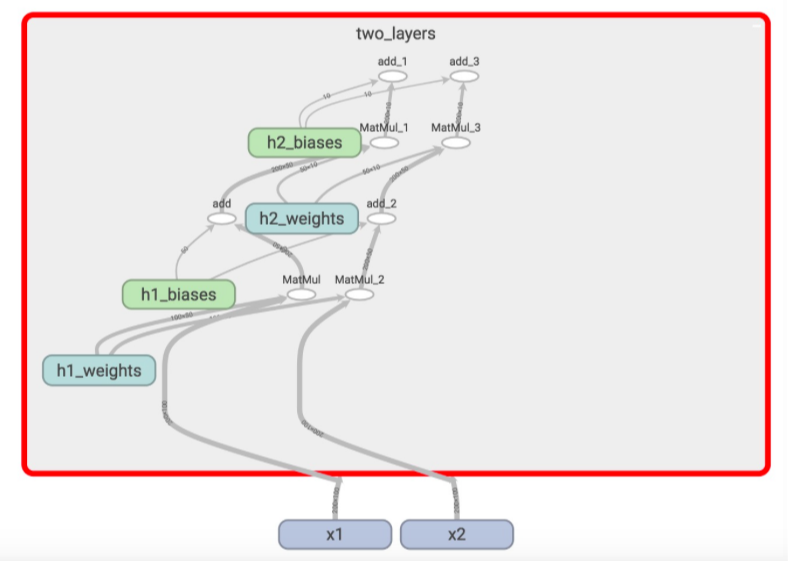

In [13]:
from IPython.display import Image
Image("images/shareing_variable_problem_fixed.png")

### Only one set of variables, all within the variable scope “two_layers”
### They take in two different inputs

### tf.variable_scope implicitly creates a name scope

## Reusable code?

<pre><code>
def two_hidden_layers(x):
    assert x.shape.as_list() == [200, 100]
    w1 = tf.get_variable("h1_weights", [100, 50], initializer=tf.random_normal_initializer())
    b1 = tf.get_variable("h1_biases", [50], initializer=tf.constant_initializer(0.0))
    h1 = tf.matmul(x, w1) + b1
    assert h1.shape.as_list() == [200, 50]  
    w2 = tf.get_variable("h2_weights", [50, 10], initializer=tf.random_normal_initializer())
    b2 = tf.get_variable("h2_biases", [10], initializer=tf.constant_initializer(0.0))
    logits = tf.matmul(h1, w2) + b2
    return logits
with tf.variable_scope('two_layers') as scope:
    logits1 = two_hidden_layers(x1)
    scope.reuse_variables()
    logits2 = two_hidden_layers(x2)
</code></pre>

## Layer them up

<pre><code>
def fully_connected(x, output_dim, scope):
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE) as scope:
        w = tf.get_variable("weights", [x.shape[1], output_dim], initializer=tf.random_normal_initializer())
        b = tf.get_variable("biases", [output_dim], initializer=tf.constant_initializer(0.0))
        return tf.matmul(x, w) + b

def two_hidden_layers(x):
    h1 = fully_connected(x, 50, 'h1')
    h2 = fully_connected(h1, 10, 'h2')

with tf.variable_scope('two_layers') as scope:
    logits1 = two_hidden_layers(x1)
    logits2 = two_hidden_layers(x2)
</code></pre>

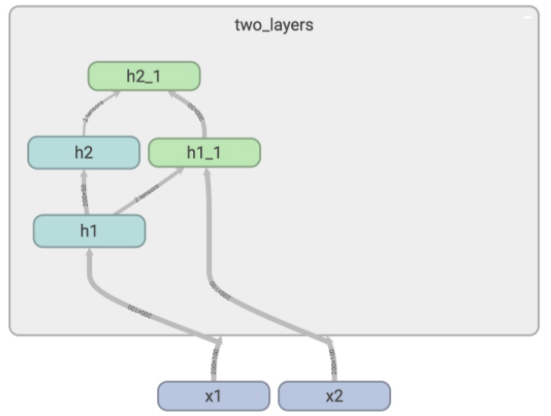

In [14]:
from IPython.display import Image
Image("images/shareing_variable_problem_layer_up.png")